<a href="https://colab.research.google.com/github/abisubramanya27/CS6910_Assignment2/blob/main/partA/src/Assignment2_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting drive to store dataset
from google.colab import drive

drive.mount('/content/gdrive')
#!rm -rf inaturalist_12K

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%time
# %cd gdrive/MyDrive/assignments/cs6910/A2/Data
# !pwd
!cp gdrive/MyDrive/assignments/cs6910/A2/Data/inaturalist_12K.zip .
#!gdown --id 11SGStqp8Vug2GDzSpJDwQYHThLIjZFQn
!unzip -q inaturalist_12K.zip
!ls

# import zipfile
# import concurrent.futures

# zf = zipfile.ZipFile('inaturalist_12K.zip')

# def unzip(file):
#     zf.extract(file)

# with concurrent.futures.ProcessPoolExecutor() as executor:
#     executor.map(unzip, zf.infolist())

^C
[inaturalist_12K.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of inaturalist_12K.zip or
        inaturalist_12K.zip.zip, and cannot find inaturalist_12K.zip.ZIP, period.
gdrive	inaturalist_12K  inaturalist_12K.zip  sample_data
CPU times: user 198 ms, sys: 34 ms, total: 232 ms
Wall time: 32.5 s


In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders

# # Splitting the training data into training and validation set
# splitfolders.ratio('./inaturalist_12K/train', output='./inaturalist_12K/output', seed=1337, ratio=(.9, .1), group_prefix=None)

In [ ]:
import os
def print_count_classes_in_valid():
  class_count_valid = {}
  for subdir, dirs, files in os.walk('./inaturalist_12K/val'):
      for file in files:
        class_count_valid[subdir] = class_count_valid.get(subdir,0)+1

  print(class_count_valid)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
from tensorflow.keras import regularizers

def build_model_partA(inp_img_shape, K_list, F_list, no_neurons_dense, no_classes = 10, pooling_list = ['max']*5, activation_fn_list = ['relu']*6, 
                      P_list = ['valid']*10, S_list = [1]*10, reg_list = ['none']*7, lambda_ = 0.01, BN_yes = False, dropout_p = 0):
    '''
    Function to build the model comprising (5 conv+relu+maxpooling layers + 1 dense FC layer) for part A in keras
    Arguments :
        inp_img_shape -- shape of input image
        K_list -- List of number of filters in each non FC layer
        F_list -- List of size of filters (assumed same dimension in width and height) in each non FC layer  
        no_neurons_dense -- Number of neurons in the dense FC layer
        no_classes -- Number of output classes in the classification problem
        pooling_list -- List of pooling layer option for each conv+pooling block ('max' : MaxPooling2D, 'avg': AveragePooling2D)
        activation_fn_list -- List of activation function in each convolution layer and the onne hidden FC layer
        P_list -- List of padding options in each non FC layer 
                  ('valid' : no padding, 'same' : padding to make input and output same dimensions)
        S_list -- List of strides (assumed equal in width and height) in each non FC layer
        reg_list -- List of regularization options for the convolution, one hidden FC and output layers ('none' : no regularization, 'L2' , 'L1')
        lambda_ -- weight decay hyperparameter for regularisation
        BN_yes -- True : Batch normalisation (BN) should be used, False : BN should not be used
        dropout_p -- Probability of dropping out a neuron
                     (The dropout is added for the single dense hidden layer alone after referring to many CNN architecture papers)

    Returns :
        model -- The keras sequential model of the CNN created
    '''
    get_regularization = {
        'none': None,
        'L1': regularizers.l1(lambda_),
        'L2': regularizers.l2(lambda_)
    }

    get_pooling_layer = {
        'max': MaxPooling2D,
        'avg': AveragePooling2D
    }

    model = Sequential()
    # First layer
    model.add(Conv2D(filters = K_list[0], kernel_size = (F_list[0], F_list[0]), strides = (S_list[0], S_list[0]), 
                     padding = P_list[0], input_shape = inp_img_shape, kernel_regularizer = get_regularization[reg_list[0]]))
    if BN_yes:
        model.add(BatchNormalization())
    model.add(Activation(activation_fn_list[0]))
    model.add(get_pooling_layer[pooling_list[0]](pool_size=(F_list[1], F_list[1]), strides = (S_list[1], S_list[1]), padding = P_list[1]))

    # 4 Conv-relu-MaxPooling layers
    for l in range(1, 5):
        model.add(Conv2D(filters = K_list[2*l], kernel_size = (F_list[2*l], F_list[2*l]), strides = (S_list[2*l], S_list[2*l]), 
                         padding = P_list[2*l], kernel_regularizer = get_regularization[reg_list[l]]))
        if BN_yes:
            model.add(BatchNormalization())
        model.add(Activation(activation_fn_list[l]))
        model.add(get_pooling_layer[pooling_list[l]](pool_size = (F_list[2*l+1], F_list[2*l+1]), strides = (S_list[2*l+1], S_list[2*l+1]), padding = P_list[2*l+1]))
    
    # 1 dense FC layer
    model.add(Flatten())
    model.add(Dropout(dropout_p))
    model.add(Dense(units = no_neurons_dense, kernel_regularizer = get_regularization[reg_list[5]]))
    if BN_yes:
        model.add(BatchNormalization())
    model.add(Activation(activation = activation_fn_list[5]))

    # Output layer
    model.add(Dense(units = no_classes, kernel_regularizer = get_regularization[reg_list[6]]))
    if BN_yes:
        model.add(BatchNormalization())
    model.add(Activation(activation = 'softmax'))

    return model
    

In [ ]:
!pip install --upgrade wandb
!wandb login 6746f968d95eb71e281d6c7772a0469574430408

     |████████████████████████████████| 2.1MB 18.2MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 163kB 50.4MB/s 
     |████████████████████████████████| 133kB 52.4MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=a4f66973f840d960185f902488c22b8a8fa5093b9d1be3ea9bb73e80f7bd9d52
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=e099af6639a6aa597effa5b97a169598a4fcc4573250a2f7cf7bfaca65709925
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from tensorflow.keras import layers

# Model for resizing and rescaling images
image_rescale = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255)
])

# Model for performing random transformations for data augmentation
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

def prepare_data(data_path, inp_img_shape, batch_size, img_preprocess, data_augmentation, data_augment_yes = False, shuffle = True):
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = image_dataset_from_directory(
        data_path, labels='inferred', color_mode='rgb', batch_size=batch_size, image_size=inp_img_shape[:-1], shuffle=shuffle,
        seed=123, label_mode='categorical'
    )
    
    dataset = dataset.map(lambda x, y: (img_preprocess(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only if data_augment_yes == True (Training set only requires data augmentation)
    if data_augment_yes:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on datasets
    return dataset.prefetch(buffer_size=AUTOTUNE)


def data_generator(inp_img_shape, batch_size, data_augment_yes = False, train_data_path = None, val_data_path = None, test_data_path = None):
    train_data = None
    if train_data_path is not None:
        train_data = prepare_data(train_data_path, inp_img_shape, batch_size, image_rescale, data_augmentation, data_augment_yes)
    val_data = None
    if val_data_path is not None:
        val_data = prepare_data(val_data_path, inp_img_shape, batch_size, image_rescale, data_augmentation, False)
    test_data = None
    if test_data_path is not None:
        test_data = prepare_data(test_data_path, inp_img_shape, batch_size, image_rescale, data_augmentation, False)
    
    return train_data, val_data, test_data


In [ ]:
# def data_generator(train_data_path, inp_img_shape, batch_size, data_augment_yes = False, val_data_path = None, test_data_path = None):
#     # Techniques for data augmentation sent to ImageDataGenerator 
#     data_augment_params = {
#         'rotation_range': 25,
#         'height_shift_range': 0.2,
#         'width_shift_range': 0.2,
#         'channel_shift_range': 40,
#         'brightness_range': (0.2, 0.7),
#         'zoom_range': 0.2,
#         'horizontal_flip': True 
#     }

#     train_gen_param = data_augment_params if data_augment_yes else dict()

#     # Generators for training, validation and test set image data for Part-A from the respective 
#     train_generator = ImageDataGenerator(rescale = 1./255, **train_gen_param).flow_from_directory(train_data_path, 
#                                                                                                   target_size = inp_img_shape[:-1], 
#                                                                                                   batch_size = batch_size, 
#                                                                                                   class_mode = 'categorical')
#     val_generator = None
#     if val_data_path is not None:
#         val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_data_path, target_size = inp_img_shape[:-1], 
#                                                                                  batch_size = batch_size, class_mode = 'categorical')  
#     test_generator = None
#     if test_data_path is not None:
#         test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_data_path, target_size = inp_img_shape[:-1], 
#                                                                                   batch_size = batch_size, class_mode = 'categorical')
    
#     return train_generator, val_generator, test_generator


In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
def train_model(model, train_data, loss_function, optimizer = 'adam', learning_rate = 1e-3, epochs = 10, val_data = None):
    if optimizer == 'adam':
        model.compile(optimizer = Adam(learning_rate=learning_rate), loss = loss_function, metrics = ['accuracy'])
    elif optimizer == 'momentum':
        model.compile(optimizer = SGD(learning_rate=learning_rate, momentum = 0.9), loss = loss_function, metrics = ['accuracy'])
    elif optimizer == 'rmsprop':
        model.compile(optimizer = RMSprop(learning_rate=learning_rate), loss = loss_function, metrics = ['accuracy'])
    elif optimizer == 'nesterov':
        model.compile(optimizer = SGD(learning_rate=learning_rate, momentum = 0.9, nesterov = True), loss = loss_function, metrics = ['accuracy'])
    elif optimizer == 'nadam':
        model.compile(optimizer = Nadam(learning_rate=learning_rate), loss = loss_function, metrics = ['accuracy'])
    else:
        model.compile(optimizer = SGD(learning_rate=learning_rate), loss = loss_function, metrics = ['accuracy'])

    model.fit(train_data,
              epochs = epochs, 
              validation_data = val_data,
              verbose = 2,
              callbacks = [WandbCallback(monitor='val_accuracy'), EarlyStopping(monitor='val_accuracy', patience=5)])
    
    return model


In [ ]:
def get_klist(start1, factor):
    start = start1
    vals = []
    for i in range(5):
        vals.append(start)
        vals.append(start)
        start = max(int(start*factor), 1)
    return vals

In [ ]:
def test_model(model, test_data):
    assert(test_data is not None)
    test_loss, test_accuracy = model.evaluate(test_data, use_multiprocessing = True, workers = 4)
    test_accuracy = round(test_accuracy*100, 2)
    test_loss = round(test_loss, 4)
    print(f'Test Accuracy : {test_accuracy} | Test Loss : {test_loss}')

    return test_loss, test_accuracy


In [ ]:
def CNN_train(inp_img_shape, train_data_path, K_list, F_list, config, no_classes = 10, pooling_list = ['max']*5, activation_fn_list = ['relu']*6, 
              P_list = ['valid']*10, S_list = [1]*10, reg_list = ['none']*7, val_data_path = None, test_data_path = None, 
              wandb_init = True, load_run = None):
    
    id = ''
    if wandb_init:
        id = wandb.util.generate_id()
        run = wandb.init(id = id, project="assignment2", entity="abisheks", reinit=True, config=config)
        
    tf.keras.backend.clear_session()

    if load_run is None:
        model = build_model_partA(inp_img_shape, K_list, F_list, config['no_neurons_dense'], no_classes, pooling_list, activation_fn_list, 
                                  P_list, S_list, reg_list, config['weight_decay'], config['batch_normalization'], config['dropout'])
    else:
        prev_model_file = wandb.restore('model-best.h5', 'abisheks/assignment2/'+load_run)
        model = tf.keras.models.load_model(prev_model_file.name)

    assert(train_data_path is not None)
    train_data, val_data, test_data = data_generator(inp_img_shape, config['batch_size'], config['data_augmented'], 
                                                     train_data_path, val_data_path, test_data_path)
    model = train_model(model, train_data, config['loss_function'], config['optimizer'], config['learning_rate'], config['epochs'], val_data)
    
    if test_data is not None:
        test_loss, test_accuracy = test_model(model, test_data)
        wandb.log({'test_accuracy': test_accuracy, 'test_loss': test_loss})

    if wandb_init:
        run.finish()

    return model, id


In [ ]:
# Hyperparameters for building the model for Part-A
K_list_1 = [32, 32, 32, 32, 64, 64, 64, 64, 128, 128]           # List of number of filters in each non FC layer
F_list_1 = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]                       # List of size of filters in each non FC layer  
activation_fn_list_1 = ['relu']*6                               # List of activation function in each convolution and FC layer
P_list_1 = ['valid']*10                                         # List of padding options in each non FC layer ('valid' : no padding, 'same' : padding to make input and output same dimensions)
S_list_1 = [1, 2, 1, 2, 1, 2, 1, 2, 1, 1]                       # List of number of strides in each non FC layer
reg_list_1 = ['L2', 'L2', 'L2', 'L2', 'L2', 'L2', 'L2']         # List of regularization options for the convolution, one hidden FC and output layers ('none' : no regularization, 'L2' , 'L1')
inp_img_shape_1 = (227, 227, 3)                                 # Shape of input image from data
no_classes_1 = 10                                               # Number of output classes in the classification problem
pooling_list_1 = ['max']*4 + ['avg']                            # List of pooling layer option for each conv+pooling block ('max' : MaxPooling2D, 'avg': AveragePooling2D)

config_1 = {
    "learning_rate": 1e-3,                                      # Hyperparameter for updating the parameters in gradient descent
    "epochs": 10,                                               # Number of epochs to train the model   
    "optimizer": 'nesterov',                                    # Gradient descent algorithm used for the parameter updation
    "batch_size": 64,                                           # Batch size used for the optimizer
    "loss_function": 'categorical_crossentropy',                # Loss function used in the optimizer
    "architecture": 'CNN',                                      # Type of neural network used
    "dataset": "iNaturalist_12K",                               # Name of dataset
    'no_filters': 32,                                           # Number of filters for the first convolution layer
    'filter_organization': 1,                                   # The factor by which the number of filters change in the subseqeuent convolution layers
    'no_neurons_dense': 64,                                     # Number of neurons in the dense FC layer
    'data_augmented': False,                                    # True : Data augmentation is done during training, False : No data augmentation done
    'dropout' : 0.2,                                            # Probability of dropping out a neuron in dropout technique
    'batch_normalization': True,                                # True : Batch normalisation (BN) should be used, False : BN should not be used
    'weight_decay': 0.01,                                       # weight decay hyperparameter for regularization
    'F_list': F_list_1,
    'activation_fn_list': activation_fn_list_1,
    'P_list': P_list_1,
    'S_list': S_list_1,
    'regularization_list': reg_list_1,
    'input_image_shape': inp_img_shape_1,
    'pooling_layer_list': pooling_list_1
}


# PART-A, Question 1 -- Building a model with (5 conv+relu+maxpooling layers + 1 dense FC layer) for image classification objective 
# modelA, _ = CNN(inp_img_shape_1, './inaturalist_12K/train', get_klist(32, 1.5), F_list_1, config_1, no_classes_1, 
#                 pooling_list_1, activation_fn_list_1, P_list_1, S_list_1, reg_list_1, './inaturalist_12K/val', './inaturalist_12K/test')

In [ ]:
sweep_config = {
    'name': 'CNN',
    'method': 'bayes',                   # Possible search : grid, random, bayes
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'no_filters': {
            'values': [32, 64]
        },
        'filter_organization': {
            'values': [1, 1.5, 2]
        },
        'data_augmented': {
            'values': [True, False]
        },
        'dropout' :{
            'values': [0, 0.25, 0.4]
        },
        'batch_normalization': {
            'values': [True, False]
        },
        'no_neurons_dense': {
            'values': [32, 64, 256]
        },
        'optimizer': {
            'values': ['adam', 'nesterov']
        },
        'weight_decay': {
            'values': [0.01, 0.001]
        }
    }
}

In [ ]:
def sweep_wrapper(data_path = './inaturalist_12K'):
  
    # Wrapper function to call the CNN function for sweeping with different hyperparameters
    # loss - (string) Loss function used. Takes values only in ['cross-entropy', 'squared-error']

    # Default values for hyper-parameters we're going to sweep over
    config_defaults =  {
        'no_filters': 32,
        'filter_organization': 1,
        'data_augmented': True, 
        'dropout' : 0.2,
        'batch_normalization': True,
        'no_neurons_dense': 64,
        'optimizer': 'nesterov',
        'weight_decay': 0.01
    }

    config_defaults.update(config_1)

    # Initialize a new wandb run
    run = wandb.init(config=config_defaults, reinit=True)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    wandb.run.name = f'nf_{config.no_filters}_fo_{config.filter_organization}_dr_{config.dropout}'
    wandb.run.name += '_da' if config.data_augmented else '' 
    wandb.run.name += '_bn' if config.batch_normalization else ''
    wandb.run.save()
    print(wandb.run.name)

    # Sweep uses L2 regularisation as default as given in the question
    modelA, _ = CNN_train(inp_img_shape_1, f'{data_path}/train', get_klist(config.no_filters, config.filter_organization), F_list_1,
                          config, no_classes_1, pooling_list_1, activation_fn_list_1, P_list_1, S_list_1, reg_list_1, 
                          f'{data_path}/val', wandb_init = False)
    run.finish()

In [ ]:
#sweep_id = wandb.sweep(sweep_config, entity="abisheks", project="assignment2")
# sweep_id = "abisheks/assignment2/1zkoctgf"
# wandb.agent(sweep_id, lambda : sweep_wrapper())

In [ ]:
import numpy as np

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

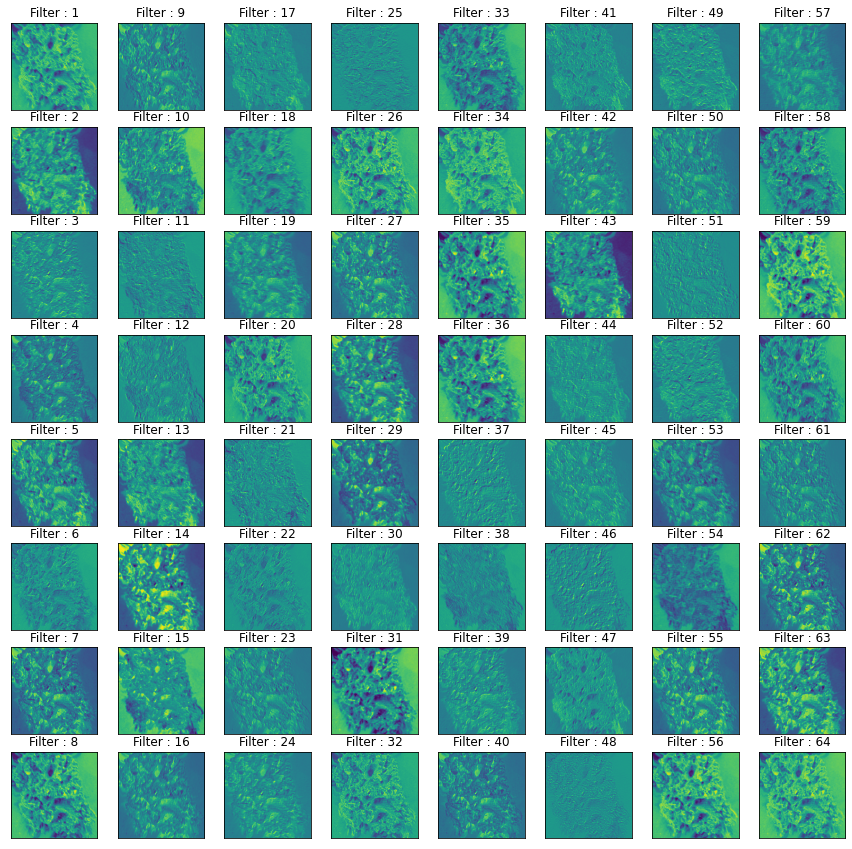

In [ ]:
import yaml
from IPython.display import Image, display
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image

def analyze_best_model_partA(wandb_log = False):
    best_run_path = 'abisheks/assignment2/huyhhsb4'
    model_file = wandb.restore('model-best.h5', best_run_path)
    model = tf.keras.models.load_model(model_file.name)
    config_file = wandb.restore('config.yaml', best_run_path)
    with open(config_file.name, 'r') as file:
        config = yaml.safe_load(file)

    # _, _, test_data = data_generator(config['input_image_shape']['value'], config['batch_size']['value'], test_data_path = './inaturalist_12K/test')
    # test_loss, test_accuracy = test_model(model, test_data)
    
    random_image_path = random.sample(glob.glob('./inaturalist_12K/test/*/*'), 1)[0]
    rand_inp_image = np.array(Image.open(random_image_path).resize(config['input_image_shape']['value'][:-1]))
    
    layer = model.get_layer(name = 'conv2d')
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
    layer_outputs = intermediate_model.predict(rand_inp_image.reshape(1, *rand_inp_image.shape))

    R, C = 8, 8
    fig, ax = plt.subplots(R, C, figsize=(15, 15))
    for i in range(R):
        for j in range(C):
            idx = i*C + j
            ax[i][j].set_title(f'Filter : {idx+1}')
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].imshow(deprocess_image(layer_outputs[0][:,:,idx]), cmap='viridis')
    
    plt.savefig('filter_visualize.png')
    plt.imsave('random_image.png', np.array(Image.open(random_image_path)))

    if wandb_log:
        run = wandb.init(project="assignment2", entity="abisheks", reinit=True, config=config)
        wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})
        run.finish()

analyze_best_model_partA()